In [1]:
import requests 
import pandas as pd
from random import sample 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys 
import math
from networkx.algorithms.community import greedy_modularity_communities

### Generating Data from Transition Matrix

In [2]:
# Arbitrary chosen params
states = ["a","b","c","d"]
state_to_index = {"a":0,"b":1,"c":2,"d":3}
initial_probabilties = [0.1, 0.3, 0.5, 0.1]
transition_matrix = np.asarray([
                                [0.1, 0.9, 0.0, 0.0],
                                [0.5, 0.2, 0.2, 0.1],
                                [0.3, 0.3, 0.3, 0.1],
                                [0.2, 0.2, 0.2, 0.4]
                              ])

In [3]:
# arbitraily decide length of produced sequence
path_length = 10

# generate start state
current_index = np.random.choice(list(range(len(states))), p=initial_probabilties)
current_state = states[current_index]

generated_state_set = [current_state]

# generate sequential states
for _ in range(path_length-1):
    next_index = np.random.choice(list(range(len(states))), p=transition_matrix[current_index])
    next_state = states[next_index]
    generated_state_set.append(next_state)
    current_index = next_index
    
print("generated state set:", generated_state_set)

generated state set: ['c', 'a', 'b', 'b', 'b', 'c', 'a', 'b', 'a', 'b']


### Calculate LL of Given Sequence

In [4]:
LL_i = 0

# calculate LL of initial state
prev_state = generated_state_set[0]
prev_index = state_to_index[prev_state]
LL_i += math.log(initial_probabilties[prev_index])

# calculate entire sequence probabilty
for current_state in generated_state_set:
    current_index = state_to_index[current_state]
    LL_i += math.log(transition_matrix[prev_index][current_index])
    prev_index = current_index

print("LL =", LL_i)

LL = -10.14260805837348


### Generate Transition Matrix from Data
#### Generate Data

In [5]:
# arbitraily decide length of produced sequence
path_length = 10
number_data_sets = 10000
generated_sets = []

for _ in range(number_data_sets):
    # generate start state
    current_index = np.random.choice(list(range(len(states))), p=initial_probabilties)
    current_state = states[current_index]

    generated_state_set = [current_state]

    # generate sequential states
    for _ in range(path_length-1):
        next_index = np.random.choice(list(range(len(states))), p=transition_matrix[current_index])
        next_state = states[next_index]
        generated_state_set.append(next_state)
        current_index = next_index
    
    generated_sets.append(generated_state_set)

print(generated_sets[:5])

[['c', 'c', 'd', 'b', 'a', 'b', 'b', 'd', 'c', 'b'], ['c', 'c', 'a', 'b', 'a', 'b', 'c', 'b', 'a', 'a'], ['b', 'a', 'b', 'a', 'b', 'c', 'a', 'b', 'b', 'b'], ['a', 'b', 'b', 'b', 'a', 'b', 'a', 'b', 'd', 'd'], ['c', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']]


note: I think it makes sense to do lapace smoothing for seq length generation, due to dynamics of inserting a gene

#### Generate Transition Matrix for 1st order MC from Data

In [6]:
observed_states = np.sort(np.unique(np.concatenate(generated_sets)))
state_to_index = {observed_states[i]: i for i in range(len(observed_states))}
estimated_transition_matrix = np.asarray([[0.0]*len(observed_states)]*len(observed_states))
estimated_intial_states = np.asarray([0.0]*len(observed_states))

for generated_set in generated_sets:
    current_index = state_to_index[generated_set[0]]
    estimated_intial_states[current_index] += 1.0
    
    for next_state in generated_set[1:]:
        next_index = state_to_index[next_state]
        estimated_transition_matrix[current_index][next_index] += 1.0
        current_index = next_index
        
estimated_intial_states = estimated_intial_states/sum(estimated_intial_states)    
for i in range(len(estimated_transition_matrix)):
    estimated_transition_matrix[i] = estimated_transition_matrix[i]/(sum(estimated_transition_matrix[i]) if sum(estimated_transition_matrix[i])>0 else 1)
    
print(estimated_intial_states)
print(estimated_transition_matrix)

[0.1012 0.3047 0.4939 0.1002]
[[0.09878058 0.90121942 0.         0.        ]
 [0.49952369 0.19915081 0.20064778 0.10067772]
 [0.30263962 0.30036121 0.29663795 0.10036121]
 [0.19616808 0.20291748 0.2045504  0.39636403]]


In [7]:
print("Difference Between Observed and Estimated Initial State Probabilties")
print(initial_probabilties - estimated_intial_states)

print("Difference Between Observed and Estimated Transition Matrix")
print(transition_matrix - estimated_transition_matrix)

Difference Between Observed and Estimated Initial State Probabilties
[-0.0012 -0.0047  0.0061 -0.0002]
Difference Between Observed and Estimated Transition Matrix
[[ 0.00121942 -0.00121942  0.          0.        ]
 [ 0.00047631  0.00084919 -0.00064778 -0.00067772]
 [-0.00263962 -0.00036121  0.00336205 -0.00036121]
 [ 0.00383192 -0.00291748 -0.0045504   0.00363597]]


#### Calculate LL of Transition Matrix for all Observed Sequences Against the Estimated Markov Chain

In [8]:
LL = 0

for generated_set in generated_sets:
    LL_i = 0
    current_index = state_to_index[generated_set[0]]
    LL_i += math.log(estimated_intial_states[current_index])
    
    for next_state in generated_set[1:]:
        next_index = state_to_index[next_state]
        LL_i += math.log(estimated_transition_matrix[current_index][next_index])
        current_index = next_index
        
    LL += LL_i
print(LL)

-100923.81605560696


### Generate Sequences that have Conserved Core Regions


In [66]:
core_region_1 = ['a1','a2','a3','a4']
core_region_2 = ['b1','b2','b3','b4']
core_region_3 = ['c1','c2','c3','c4']
variable_elements = ['d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

genome_length = 60
number_genomes = 1000
generated_sets = []

for _ in range(number_genomes):
    # 1. randomly pick subset of and mix up variable elements
    genome_template = []

    # 2. insert mixed up core elements
#     mixed_core_1 = np.random.choice(core_region_1, len(core_region_1), replace = False)
#     mixed_core_2 = np.random.choice(core_region_2, len(core_region_2), replace = False)
#     mixed_core_3 = np.random.choice(core_region_3, len(core_region_3), replace = False)
    
    mixed_core_1 = core_region_1
    mixed_core_2 = core_region_2
    mixed_core_3 = core_region_3
    
    insertion_range = np.array(range(genome_length-len(core_region_1)))
    insertion_locations = np.random.choice(insertion_range, 3)
    
    # 3. chose where to insert core genomes
    while len(genome_template) <= genome_length:
    
        if len(genome_template) == insertion_locations[0]:
            genome_template = genome_template + core_region_1
        elif len(genome_template) == insertion_locations[1]:
            genome_template = genome_template + core_region_2
        elif len(genome_template) == insertion_locations[2]:
            genome_template = genome_template + core_region_3
        else:
            genome_template = genome_template + [np.random.choice(variable_elements)]
    

    generated_sets.append(genome_template)


In [67]:
generated_sets[:2]

[['z',
  'g',
  'n',
  'l',
  'q',
  'r',
  'q',
  'z',
  'x',
  'e',
  'j',
  'n',
  'n',
  'x',
  'h',
  'a1',
  'a2',
  'a3',
  'a4',
  'h',
  'j',
  'b1',
  'b2',
  'b3',
  'b4',
  'x',
  'p',
  'p',
  'p',
  'q',
  'l',
  'l',
  'x',
  'r',
  'f',
  'h',
  'q',
  'e',
  'k',
  'i',
  'r',
  'l',
  'm',
  'f',
  'm',
  'v',
  'y',
  'g',
  'd',
  'r',
  'g',
  'h',
  'j',
  'f',
  'q',
  'c1',
  'c2',
  'c3',
  'c4',
  'f',
  'l'],
 ['k',
  's',
  'g',
  'v',
  'q',
  'k',
  'x',
  'w',
  'y',
  'j',
  'k',
  't',
  'b1',
  'b2',
  'b3',
  'b4',
  'q',
  'n',
  'd',
  'r',
  't',
  'c1',
  'c2',
  'c3',
  'c4',
  'l',
  'q',
  'z',
  't',
  'u',
  'p',
  't',
  'u',
  'w',
  'z',
  'i',
  'p',
  't',
  'h',
  's',
  'p',
  's',
  'k',
  'g',
  'a1',
  'a2',
  'a3',
  'a4',
  'd',
  'r',
  'z',
  'z',
  'g',
  'p',
  'h',
  'i',
  'k',
  'k',
  'v',
  'u',
  'm']]

#### First order markov chain

In [68]:
def first_order_markov(data):
    observed_states = np.sort(np.unique(np.concatenate(generated_sets)))
    state_to_index = {observed_states[i]: i for i in range(len(observed_states))}
    estimated_transition_matrix = np.asarray([[0.0]*len(observed_states)]*len(observed_states))
    estimated_intial_states = np.asarray([0.0]*len(observed_states))

    for generated_set in data:
        current_index = state_to_index[generated_set[0]]
        estimated_intial_states[current_index] += 1.0

        for next_state in generated_set[1:]:
            next_index = state_to_index[next_state]
            estimated_transition_matrix[current_index][next_index] += 1.0
            current_index = next_index

    estimated_intial_states = estimated_intial_states/sum(estimated_intial_states)    
    for i in range(len(estimated_transition_matrix)):
        estimated_transition_matrix[i] = estimated_transition_matrix[i]/(sum(estimated_transition_matrix[i]) if sum(estimated_transition_matrix[i])>0 else 1)
    
    return observed_states, estimated_intial_states, estimated_transition_matrix

In [69]:
observed_states, estimated_intial_states, estimated_transition_matrix = first_order_markov(generated_sets)

Log Likelihood of 1st order markov chain

In [70]:
def calculate_first_order_LL(data, transition_matrix, initial_states, states):
    LL = 0
    
    state_to_index = {}
    for i in range(len(states)):
        state_to_index[states[i]] = i
        
        
    for generated_set in generated_sets:
        LL_i = 0
        current_index = state_to_index[generated_set[0]]
        LL_i += math.log(initial_states[current_index])

        for next_state in generated_set[1:]:
            next_index = state_to_index[next_state]
            LL_i += math.log(transition_matrix[current_index][next_index])
            current_index = next_index

        LL += LL_i
    return LL

In [71]:
print(calculate_first_order_LL(generated_sets, estimated_transition_matrix, estimated_intial_states, observed_states))

-170797.50658551778


Trying greedy clustering algorithm

In [72]:
G_markov = nx.from_numpy_matrix(estimated_transition_matrix)
groupings = greedy_modularity_communities(G_markov, weight=None)

for g in range(30):
    print("GROUP ",g)
    for i in groupings[g]:
        print(observed_states[i])
    print()
    print()

GROUP  0
a2
a3


GROUP  1
b2
b3


GROUP  2
c2
c3


GROUP  3
a1


GROUP  4
a4


GROUP  5
b1


GROUP  6
b4


GROUP  7
c1


GROUP  8
c4


GROUP  9
d


GROUP  10
e


GROUP  11
f


GROUP  12
g


GROUP  13
h


GROUP  14
i


GROUP  15
j


GROUP  16
k


GROUP  17
l


GROUP  18
m


GROUP  19
n


GROUP  20
o


GROUP  21
p


GROUP  22
q


GROUP  23
r


GROUP  24
s


GROUP  25
t


GROUP  26
u


GROUP  27
v


GROUP  28
w


GROUP  29
x




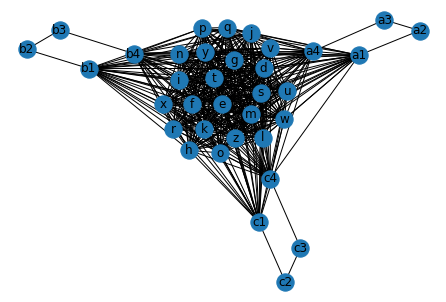

In [73]:
G_markov = nx.from_numpy_matrix(estimated_transition_matrix)
nx.draw(G_markov, with_labels = True, labels = {i:observed_states[i] for i in list(G_markov.nodes())})

Generating a Sequence using First Order Markov Chain

In [20]:
# arbitraily decide length of produced sequence
path_length = 40

# generate start state
current_index = np.random.choice(list(range(len(observed_states))), p=estimated_intial_states)
current_state = observed_states[current_index]

generated_state_set = [current_state]

# generate sequential states
for _ in range(path_length-1):
    next_index = np.random.choice(list(range(len(observed_states))), p=estimated_transition_matrix[current_index])
    next_state = observed_states[next_index]
    generated_state_set.append(next_state)
    current_index = next_index
    
print("generated state set:", generated_state_set)

generated state set: ['m', 'h', 'f', 'n', 'b1', 'b2', 'b3', 'b4', 'a1', 'a2', 'a3', 'a4', 's', 'x', 'n', 'z', 'd', 'p', 's', 's', 'h', 'o', 'q', 'z', 'x', 'b1', 'b2', 'b3', 'b4', 's', 'p', 'u', 'w', 'g', 'x', 'z', 'l', 's', 'r', 'w']


In [96]:
core_region_1 = ['a1','a2','a3','a4']
core_region_2 = ['b1','b2','b3','b4']
core_region_3 = ['c1','c2','c3','c4','c5']
variable_elements = ['d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

genome_length = 60
number_genomes = 1000
generated_sets = []

for _ in range(number_genomes):
    # 1. randomly pick subset of and mix up variable elements
    genome_template = []

    # 2. insert mixed up core elements
    mixed_core_1 = np.random.shuffle(core_region_1)
    mixed_core_2 = np.random.shuffle(core_region_2)
    mixed_core_3 = np.random.shuffle(core_region_3)
    
    mixed_core_1 = core_region_1
    mixed_core_2 = core_region_2
    mixed_core_3 = core_region_3
    
    insertion_range = np.array(range(genome_length-3*len(core_region_1)))
    insertion_locations = np.random.choice(insertion_range, 3, replace = False)
    
    # 3. chose where to insert core genomes
    position = 0
    while len(genome_template) <= genome_length:
    
        if position == insertion_locations[0]:
            genome_template = genome_template + core_region_1
        if position == insertion_locations[1]:
            genome_template = genome_template + core_region_2
        if position == insertion_locations[2]:
            genome_template = genome_template + core_region_3
        else:
            genome_template = genome_template + [np.random.choice(variable_elements)]
    
        position += 1
    generated_sets.append(genome_template)


In [97]:
generated_sets[:2]

[['o',
  'w',
  'c2',
  'c3',
  'c1',
  'c4',
  'c5',
  'g',
  'p',
  'k',
  'n',
  'g',
  'p',
  'p',
  'v',
  'y',
  'v',
  'o',
  'g',
  'b4',
  'b1',
  'b2',
  'b3',
  'o',
  'h',
  'l',
  'o',
  'r',
  'k',
  'e',
  'u',
  'f',
  'a4',
  'a2',
  'a1',
  'a3',
  'n',
  'w',
  'y',
  's',
  'r',
  'i',
  'w',
  'm',
  'w',
  'z',
  'h',
  'm',
  'd',
  'l',
  'u',
  'h',
  'e',
  'n',
  'm',
  'd',
  'l',
  'k',
  'i',
  'p',
  'y'],
 ['a3',
  'a4',
  'a1',
  'a2',
  'p',
  'k',
  'v',
  't',
  'q',
  'o',
  'd',
  'n',
  'w',
  't',
  'i',
  'k',
  's',
  's',
  'd',
  'j',
  'w',
  'l',
  'j',
  'z',
  'v',
  'v',
  'g',
  'm',
  'x',
  'm',
  'x',
  'z',
  's',
  's',
  'l',
  'j',
  'p',
  'f',
  'w',
  'f',
  'w',
  'q',
  'u',
  'p',
  'z',
  'b2',
  'b3',
  'b1',
  'b4',
  'e',
  'i',
  'h',
  'm',
  'j',
  'c3',
  'c5',
  'c1',
  'c2',
  'c4',
  'f',
  'j']]

In [98]:
observed_states, estimated_intial_states, estimated_transition_matrix = first_order_markov(generated_sets)

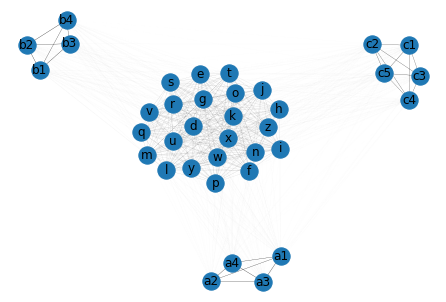

In [104]:
G_markov = nx.from_numpy_matrix(estimated_transition_matrix)
nx.draw(G_markov, with_labels = True, labels = {i:observed_states[i] for i in list(G_markov.nodes())},
       width= [G_markov[u][v]['weight'] for u,v in G_markov.edges()])
